In [1]:
# Fix for issue loading Utils.preprocess_util
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from Utils.preprocess_util import *
from Utils.visualize import *

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%reload_ext autoreload
%autoreload 2


In [9]:
print(np.unique(person_train_valid))

[0. 1. 2. 3. 4. 5. 6. 7. 8.]


In [17]:
a = np.array([1,2,4,5,1,4,1,5])
c = np.argwhere(a==4)

b = np.array([11,21,41,15,11,43,13,56])
print(b[c])

[[41]
 [43]]


In [2]:
X_train,X_valid,X_test,Y_train,Y_valid,Y_test = load_preprocess_eeg_data(person=None,crop=True)


(2115, 22, 1000)
Cropping trials
(177125, 22, 500)
After cropping:
Training data: (177125, 22, 500)
Training target: (177125,)
Validation data: (87250, 22, 500)
Validation target: (87250,)
Test data: (55375, 22, 500)
Test target: (55375,)
Person train/validation: (2115, 1)
Person test: (443, 1)

After cropping:
Training data: (177125, 22, 500)
Training target: (177125,)
Validation data: (87250, 22, 500)
Validation target: (87250,)
Test data: (55375, 22, 500)
Test target: (55375,)
Person train/validation: (2115, 1)
Person test: (443, 1)



In [3]:
indices = np.random.choice(X_train.shape[0], X_train.shape[0], replace=False)
X_train = X_train[indices]
Y_train = Y_train[indices]





In [35]:
person_train_valid = np.load('../Data/person_train_valid.npy')
print(person_train_valid.shape)

(2115, 1)


In [96]:
X_train_small = X_train[0:1000]
Y_train_small = Y_train[0:1000]

In [4]:
indices = np.random.choice(X_valid.shape[0], X_valid.shape[0], replace=False)
X_valid = X_valid[indices]
Y_valid = Y_valid[indices]

indices = np.random.choice(X_test.shape[0], X_test.shape[0], replace=False)
X_test = X_test[indices]
Y_test = Y_test[indices]

In [5]:
print(X_train.shape)

(177125, 22, 500)


In [6]:
# create feature and targets tensor for train set
features_train = torch.from_numpy(X_train)
targets_train = torch.from_numpy(Y_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set
features_test = torch.from_numpy(X_test)
targets_test = torch.from_numpy(Y_test).type(torch.LongTensor)

features_valid = torch.from_numpy(X_valid)
targets_valid = torch.from_numpy(Y_valid).type(torch.LongTensor)


In [7]:
class LSTMModel(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs,n_layers,droput):
        super(LSTMModel, self).__init__()
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.num_layers = n_layers
        self.lstm = nn.GRU(self.n_inputs, self.n_neurons,self.num_layers) 
        
        ih_size = list(self.lstm.weight_ih_l0.data.shape)
        hh_size =list(self.lstm.weight_hh_l0.data.shape)
        self.lstm.weight_ih_l0.data.copy_(torch.eye(ih_size[0],ih_size[1]))
        self.lstm.weight_hh_l0.data.copy_(torch.eye(hh_size[0],hh_size[1]))
        
        self.lstm.bias_ih_l0.data.fill_(0)
        self.lstm.bias_hh_l0.data.fill_(0)
        
        
        self.droput = nn.Dropout(p=droput)
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
            # (num_layers, batch_size, n_neurons)
            return (torch.zeros(self.num_layers, self.batch_size, self.n_neurons))
            #return torch.nn.init.xavier_uniform_((self.num_layers, self.batch_size, self.n_neurons), gain=1)

    def forward(self, X):
            # transforms X to (n_steps, batch_size, n_inputs)
            X = X.permute(1, 0, 2) 
            self.batch_size = X.size(1)
            self.hidden = self.init_hidden()
            lstm_out, self.hidden= self.lstm(X, self.hidden)
            hidden_out =self.hidden[self.num_layers-1]
            dropout_out = self.droput(hidden_out)
            out = self.FC(dropout_out)

            return out.view(-1, self.n_outputs) # (batch_size, n_output)


In [14]:
batch_size = 500
# Pytorch train and test sets
train = torch.utils.data.TensorDataset(features_train, targets_train)
valid = torch.utils.data.TensorDataset(features_valid, targets_valid)
test = torch.utils.data.TensorDataset(features_test, targets_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

# pprint.pprint(test_loader.dataset.tensors[0].size())


In [23]:
N_STEPS = 500
N_INPUTS = 22
N_NEURONS = 200
N_OUTPUTS = 10
N_EPOCHS = 10
N_LAYERS = 1# This actually corresponds to how many lsts are stacked one above the other
droput = 0
dataiter = iter(train_loader)
images, labels = dataiter.next()
model = LSTMModel(batch_size, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS,N_LAYERS,droput)

# (batch_size, n_steps, n_inputs)
images_modified = images.view(-1, 500, 22)
logits = model(images_modified.float())
print(logits[0:10])

tensor([[-0.0158, -0.0287, -0.0124, -0.0551, -0.0352,  0.0486, -0.0373, -0.0135,
         -0.0146,  0.0203],
        [-0.0158, -0.0287, -0.0124, -0.0551, -0.0352,  0.0486, -0.0373, -0.0135,
         -0.0146,  0.0203],
        [-0.0158, -0.0287, -0.0124, -0.0551, -0.0352,  0.0486, -0.0373, -0.0135,
         -0.0146,  0.0203],
        [-0.0158, -0.0287, -0.0124, -0.0551, -0.0352,  0.0486, -0.0373, -0.0135,
         -0.0146,  0.0203],
        [-0.0158, -0.0287, -0.0124, -0.0551, -0.0352,  0.0486, -0.0373, -0.0135,
         -0.0146,  0.0203],
        [-0.0158, -0.0287, -0.0124, -0.0551, -0.0352,  0.0486, -0.0373, -0.0135,
         -0.0146,  0.0203],
        [-0.0158, -0.0287, -0.0124, -0.0551, -0.0352,  0.0486, -0.0373, -0.0135,
         -0.0146,  0.0203],
        [-0.0158, -0.0287, -0.0124, -0.0551, -0.0352,  0.0486, -0.0373, -0.0135,
         -0.0146,  0.0203],
        [-0.0158, -0.0287, -0.0124, -0.0551, -0.0352,  0.0486, -0.0373, -0.0135,
         -0.0146,  0.0203],
        [-0.0158, -

In [24]:
dtype = torch.FloatTensor
n_iters = 10000
num_epochs = int(n_iters / (len(X_train)/batch_size))
model = LSTMModel(batch_size, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS,N_LAYERS,droput)

# Cross Entropy Loss 
loss_fn = nn.CrossEntropyLoss().type(dtype)

# batch GD
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01,weight_decay =0,betas=(0.9, 0.999),amsgrad=False)
#optimizer = torch.optim.RMSprop(model.parameters(),lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.1)

# Create RNN
input_dim = 22
seq_dim = 500

train_loss = []
iterations = []
train_acc = []

X_valid_tensor = torch.from_numpy(X_valid.reshape(-1, seq_dim, input_dim))
X_train_tensor = torch.from_numpy(X_train.reshape(-1, seq_dim, input_dim))

print("num_epochs = ", num_epochs)
print("n_iters = ", n_iters)
print("starting training..")

count = 0
#num_epochs = 2
print("starting training..")
for epoch in range(num_epochs):
    print("epoch=",epoch)
    # reset hidden states
    
    for i, (signals, labels) in enumerate(train_loader):
        train  = Variable(signals.view(-1, seq_dim, input_dim))
        labels = Variable(labels )
        
        # Clear gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
                
        # Forward propagation
        outputs = model(train.float())
        
        # Calculate softmax and cross entropy loss
        loss = loss_fn(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
                    
        #print("parameters===",list(model.parameters())[0].data)

        count += 1
        train_loss.append(loss.data)
        iterations.append(count)
        if count % 1 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            
            #indices = np.random.choice(X_train.shape[0], 50, replace=False)
            #X_train_tensor = torch.from_numpy(X_train[indices].reshape(-1, seq_dim, input_dim))
            #y_pred_valid = model( X_valid_tensor.float())
            #val_acc = get_accuracy(y_pred_valid, Y_valid,batch_size=X_valid.shape[0])
            
            y_pred_train = model( train.float())
            train_acc = get_accuracy(y_pred_train,labels,batch_size=labels.shape[0])
            
            indices = np.random.choice(X_valid.shape[0], 50, replace=False)
            
            X_valid_tensor = torch.from_numpy(X_valid[indices].reshape(-1, seq_dim, input_dim))
            
            y_pred_valid = model( X_valid_tensor.float())
            val_acc = get_accuracy(y_pred_valid, Y_valid[indices],
            batch_size=50)
            
            #print('Iteration: {}  Loss: {}' .format(count, loss.data))

            print('Iteration: {}  Loss: {}  Train Accuracy: {} Valid Accuracy: {} %'.format(count, loss.data,train_acc,
                                                                                            val_acc))
            #if(train_acc> 35 and val_acc>35):
                #return
            '''
            # Iterate through test dataset
            for signals, labels in valid_loader:
                signals = Variable(signals.view(-1, seq_dim, input_dim))
                #print(signals.shape)
                # Forward propagation
                outputs_valid = model(signals.float())

                # Get predictions from the maximum value
                predicted = torch.max(outputs_valid.data, 1)[1]
                
                # Total number of labels
                total += labels.size(0)
                correct += (predicted == labels).sum()
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            train_loss.append(loss.data)
            iterations.append(count)
            train_acc.append(accuracy)
            print('Iteration: {}  Loss: {}  Valid Accuracy: {} %'.format(count, loss.data, accuracy))
          '''  
                                   

num_epochs =  28
n_iters =  10000
starting training..
starting training..
epoch= 0
Iteration: 1  Loss: 2.3085198402404785  Train Accuracy: 0.0 Valid Accuracy: 0.0 %
Iteration: 2  Loss: 2.3110010623931885  Train Accuracy: 0.0 Valid Accuracy: 0.0 %
Iteration: 3  Loss: 2.311781406402588  Train Accuracy: 0.0 Valid Accuracy: 0.0 %
Iteration: 4  Loss: 2.3107078075408936  Train Accuracy: 0.0 Valid Accuracy: 0.0 %
Iteration: 5  Loss: 2.308931350708008  Train Accuracy: 0.0 Valid Accuracy: 0.0 %
Iteration: 6  Loss: 2.309894323348999  Train Accuracy: 0.0 Valid Accuracy: 0.0 %
Iteration: 7  Loss: 2.3094358444213867  Train Accuracy: 0.0 Valid Accuracy: 0.0 %
Iteration: 8  Loss: 2.3119912147521973  Train Accuracy: 0.0 Valid Accuracy: 0.0 %
Iteration: 9  Loss: 2.312741756439209  Train Accuracy: 0.0 Valid Accuracy: 0.0 %
Iteration: 10  Loss: 2.31199049949646  Train Accuracy: 0.0 Valid Accuracy: 0.0 %
Iteration: 11  Loss: 2.309495449066162  Train Accuracy: 0.0 Valid Accuracy: 0.0 %
Iteration: 12  Loss:

Iteration: 100  Loss: 2.3050100803375244  Train Accuracy: 0.0 Valid Accuracy: 0.0 %
Iteration: 101  Loss: 2.3044230937957764  Train Accuracy: 0.0 Valid Accuracy: 0.0 %
Iteration: 102  Loss: 2.3054287433624268  Train Accuracy: 0.2 Valid Accuracy: 0.0 %
Iteration: 103  Loss: 2.3043289184570312  Train Accuracy: 0.0 Valid Accuracy: 0.0 %
Iteration: 104  Loss: 2.304281711578369  Train Accuracy: 0.0 Valid Accuracy: 0.0 %
Iteration: 105  Loss: 2.3040146827697754  Train Accuracy: 0.2 Valid Accuracy: 0.0 %
Iteration: 106  Loss: 2.302905321121216  Train Accuracy: 0.0 Valid Accuracy: 0.0 %
Iteration: 107  Loss: 2.300880193710327  Train Accuracy: 0.0 Valid Accuracy: 0.0 %
Iteration: 108  Loss: 2.3035855293273926  Train Accuracy: 0.0 Valid Accuracy: 0.0 %
Iteration: 109  Loss: 2.3042123317718506  Train Accuracy: 0.0 Valid Accuracy: 0.0 %
Iteration: 110  Loss: 2.3032870292663574  Train Accuracy: 0.0 Valid Accuracy: 0.0 %
Iteration: 111  Loss: 2.30366587638855  Train Accuracy: 0.2 Valid Accuracy: 0.0

Iteration: 199  Loss: 2.2929599285125732  Train Accuracy: 6.0 Valid Accuracy: 6.0 %
Iteration: 200  Loss: 2.293058156967163  Train Accuracy: 7.4 Valid Accuracy: 2.0 %
Iteration: 201  Loss: 2.290253162384033  Train Accuracy: 8.6 Valid Accuracy: 6.0 %
Iteration: 202  Loss: 2.2909812927246094  Train Accuracy: 6.8 Valid Accuracy: 10.0 %
Iteration: 203  Loss: 2.290693759918213  Train Accuracy: 7.0 Valid Accuracy: 8.0 %
Iteration: 204  Loss: 2.2894349098205566  Train Accuracy: 6.6 Valid Accuracy: 6.0 %
Iteration: 205  Loss: 2.2902841567993164  Train Accuracy: 5.8 Valid Accuracy: 4.0 %
Iteration: 206  Loss: 2.2906322479248047  Train Accuracy: 8.0 Valid Accuracy: 6.0 %
Iteration: 207  Loss: 2.2901976108551025  Train Accuracy: 8.6 Valid Accuracy: 10.0 %
Iteration: 208  Loss: 2.292163372039795  Train Accuracy: 5.4 Valid Accuracy: 10.0 %
Iteration: 209  Loss: 2.291395425796509  Train Accuracy: 7.8 Valid Accuracy: 8.0 %
Iteration: 210  Loss: 2.2891249656677246  Train Accuracy: 8.4 Valid Accuracy: 

Iteration: 296  Loss: 2.2615718841552734  Train Accuracy: 20.4 Valid Accuracy: 18.0 %
Iteration: 297  Loss: 2.2591164112091064  Train Accuracy: 23.2 Valid Accuracy: 16.0 %
Iteration: 298  Loss: 2.2600510120391846  Train Accuracy: 23.0 Valid Accuracy: 24.0 %
Iteration: 299  Loss: 2.2552850246429443  Train Accuracy: 23.8 Valid Accuracy: 18.0 %
Iteration: 300  Loss: 2.259334087371826  Train Accuracy: 22.0 Valid Accuracy: 12.0 %
Iteration: 301  Loss: 2.2547621726989746  Train Accuracy: 21.4 Valid Accuracy: 12.0 %
Iteration: 302  Loss: 2.254945755004883  Train Accuracy: 22.2 Valid Accuracy: 26.0 %
Iteration: 303  Loss: 2.2579989433288574  Train Accuracy: 22.2 Valid Accuracy: 24.0 %
Iteration: 304  Loss: 2.253835916519165  Train Accuracy: 24.2 Valid Accuracy: 22.0 %
Iteration: 305  Loss: 2.254988670349121  Train Accuracy: 21.0 Valid Accuracy: 18.0 %
Iteration: 306  Loss: 2.2550692558288574  Train Accuracy: 22.0 Valid Accuracy: 18.0 %
Iteration: 307  Loss: 2.253730297088623  Train Accuracy: 2

Iteration: 392  Loss: 1.978993535041809  Train Accuracy: 26.4 Valid Accuracy: 20.0 %
Iteration: 393  Loss: 1.9552597999572754  Train Accuracy: 22.8 Valid Accuracy: 24.0 %
Iteration: 394  Loss: 1.9335296154022217  Train Accuracy: 20.4 Valid Accuracy: 16.0 %
Iteration: 395  Loss: 1.90555739402771  Train Accuracy: 24.2 Valid Accuracy: 22.0 %
Iteration: 396  Loss: 1.8694002628326416  Train Accuracy: 24.6 Valid Accuracy: 20.0 %
Iteration: 397  Loss: 1.8128612041473389  Train Accuracy: 23.8 Valid Accuracy: 34.0 %
Iteration: 398  Loss: 1.8413532972335815  Train Accuracy: 23.4 Valid Accuracy: 36.0 %
Iteration: 399  Loss: 1.792953372001648  Train Accuracy: 24.6 Valid Accuracy: 32.0 %
Iteration: 400  Loss: 1.7501319646835327  Train Accuracy: 23.2 Valid Accuracy: 48.0 %
Iteration: 401  Loss: 1.6933071613311768  Train Accuracy: 25.4 Valid Accuracy: 34.0 %
Iteration: 402  Loss: 1.6862759590148926  Train Accuracy: 29.8 Valid Accuracy: 36.0 %
Iteration: 403  Loss: 1.6595938205718994  Train Accuracy: 

Iteration: 488  Loss: 1.400191068649292  Train Accuracy: 23.6 Valid Accuracy: 34.0 %
Iteration: 489  Loss: 1.4112322330474854  Train Accuracy: 25.6 Valid Accuracy: 20.0 %
Iteration: 490  Loss: 1.4052575826644897  Train Accuracy: 27.4 Valid Accuracy: 26.0 %
Iteration: 491  Loss: 1.4006534814834595  Train Accuracy: 26.8 Valid Accuracy: 26.0 %
Iteration: 492  Loss: 1.398046612739563  Train Accuracy: 23.4 Valid Accuracy: 24.0 %
Iteration: 493  Loss: 1.3976294994354248  Train Accuracy: 24.8 Valid Accuracy: 26.0 %
Iteration: 494  Loss: 1.40007483959198  Train Accuracy: 25.8 Valid Accuracy: 28.0 %
Iteration: 495  Loss: 1.398053765296936  Train Accuracy: 25.6 Valid Accuracy: 20.0 %
Iteration: 496  Loss: 1.3938027620315552  Train Accuracy: 27.6 Valid Accuracy: 22.0 %
Iteration: 497  Loss: 1.4056679010391235  Train Accuracy: 25.2 Valid Accuracy: 22.0 %
Iteration: 498  Loss: 1.3923934698104858  Train Accuracy: 27.8 Valid Accuracy: 22.0 %
Iteration: 499  Loss: 1.4007364511489868  Train Accuracy: 2

Iteration: 584  Loss: 1.3919249773025513  Train Accuracy: 26.4 Valid Accuracy: 20.0 %
Iteration: 585  Loss: 1.3894739151000977  Train Accuracy: 26.2 Valid Accuracy: 30.0 %
Iteration: 586  Loss: 1.3916938304901123  Train Accuracy: 24.6 Valid Accuracy: 20.0 %
Iteration: 587  Loss: 1.3927799463272095  Train Accuracy: 25.8 Valid Accuracy: 22.0 %
Iteration: 588  Loss: 1.3908547163009644  Train Accuracy: 27.2 Valid Accuracy: 22.0 %
Iteration: 589  Loss: 1.3896913528442383  Train Accuracy: 26.8 Valid Accuracy: 26.0 %
Iteration: 590  Loss: 1.3923438787460327  Train Accuracy: 26.0 Valid Accuracy: 30.0 %
Iteration: 591  Loss: 1.3909130096435547  Train Accuracy: 29.0 Valid Accuracy: 24.0 %
Iteration: 592  Loss: 1.391666293144226  Train Accuracy: 28.8 Valid Accuracy: 24.0 %
Iteration: 593  Loss: 1.3925888538360596  Train Accuracy: 25.2 Valid Accuracy: 18.0 %
Iteration: 594  Loss: 1.3890845775604248  Train Accuracy: 29.6 Valid Accuracy: 22.0 %
Iteration: 595  Loss: 1.393064260482788  Train Accuracy

Iteration: 680  Loss: 1.3894230127334595  Train Accuracy: 28.4 Valid Accuracy: 22.0 %
Iteration: 681  Loss: 1.3906735181808472  Train Accuracy: 28.2 Valid Accuracy: 30.0 %
Iteration: 682  Loss: 1.3873659372329712  Train Accuracy: 31.4 Valid Accuracy: 30.0 %
Iteration: 683  Loss: 1.3895968198776245  Train Accuracy: 24.8 Valid Accuracy: 18.0 %
Iteration: 684  Loss: 1.3924427032470703  Train Accuracy: 23.2 Valid Accuracy: 24.0 %
Iteration: 685  Loss: 1.3916263580322266  Train Accuracy: 25.6 Valid Accuracy: 20.0 %
Iteration: 686  Loss: 1.388693928718567  Train Accuracy: 29.6 Valid Accuracy: 18.0 %
Iteration: 687  Loss: 1.389968991279602  Train Accuracy: 27.0 Valid Accuracy: 16.0 %
Iteration: 688  Loss: 1.3903928995132446  Train Accuracy: 25.4 Valid Accuracy: 22.0 %
Iteration: 689  Loss: 1.3885551691055298  Train Accuracy: 30.4 Valid Accuracy: 20.0 %
Iteration: 690  Loss: 1.3902568817138672  Train Accuracy: 27.4 Valid Accuracy: 20.0 %
Iteration: 691  Loss: 1.3887687921524048  Train Accuracy

Iteration: 776  Loss: 1.3905383348464966  Train Accuracy: 26.0 Valid Accuracy: 20.0 %
Iteration: 777  Loss: 1.3886566162109375  Train Accuracy: 26.6 Valid Accuracy: 24.0 %
Iteration: 778  Loss: 1.3911185264587402  Train Accuracy: 25.4 Valid Accuracy: 22.0 %
Iteration: 779  Loss: 1.388664960861206  Train Accuracy: 28.0 Valid Accuracy: 20.0 %
Iteration: 780  Loss: 1.388736367225647  Train Accuracy: 30.2 Valid Accuracy: 32.0 %
Iteration: 781  Loss: 1.3860292434692383  Train Accuracy: 28.8 Valid Accuracy: 20.0 %
Iteration: 782  Loss: 1.3894920349121094  Train Accuracy: 26.2 Valid Accuracy: 22.0 %
Iteration: 783  Loss: 1.3905692100524902  Train Accuracy: 26.8 Valid Accuracy: 26.0 %
Iteration: 784  Loss: 1.3890175819396973  Train Accuracy: 26.2 Valid Accuracy: 22.0 %
Iteration: 785  Loss: 1.389319896697998  Train Accuracy: 25.2 Valid Accuracy: 24.0 %
Iteration: 786  Loss: 1.389140248298645  Train Accuracy: 24.4 Valid Accuracy: 26.0 %
Iteration: 787  Loss: 1.39127779006958  Train Accuracy: 25

Iteration: 872  Loss: 1.3892927169799805  Train Accuracy: 26.2 Valid Accuracy: 24.0 %
Iteration: 873  Loss: 1.389337182044983  Train Accuracy: 26.6 Valid Accuracy: 24.0 %
Iteration: 874  Loss: 1.3895671367645264  Train Accuracy: 24.8 Valid Accuracy: 28.0 %
Iteration: 875  Loss: 1.3884907960891724  Train Accuracy: 24.4 Valid Accuracy: 22.0 %
Iteration: 876  Loss: 1.3915132284164429  Train Accuracy: 24.2 Valid Accuracy: 32.0 %
Iteration: 877  Loss: 1.3880351781845093  Train Accuracy: 28.8 Valid Accuracy: 22.0 %
Iteration: 878  Loss: 1.3896689414978027  Train Accuracy: 27.0 Valid Accuracy: 10.0 %
Iteration: 879  Loss: 1.3870254755020142  Train Accuracy: 28.0 Valid Accuracy: 20.0 %
Iteration: 880  Loss: 1.3864495754241943  Train Accuracy: 29.6 Valid Accuracy: 18.0 %
Iteration: 881  Loss: 1.3902647495269775  Train Accuracy: 27.4 Valid Accuracy: 22.0 %
Iteration: 882  Loss: 1.3880211114883423  Train Accuracy: 29.4 Valid Accuracy: 22.0 %
Iteration: 883  Loss: 1.3885397911071777  Train Accurac

KeyboardInterrupt: 

In [ ]:
X_train_tensor = torch.from_numpy(X_train.reshape(-1, seq_dim, input_dim))
print(X_train_tensor.shape)
y_pred_train = model( X_train_tensor.float())
train_acc = get_accuracy(y_pred_train, Y_train,
    batch_size=len(Y_train))
print('train accuracy:', train_acc)

X_valid_tensor = torch.from_numpy(X_valid.reshape(-1, seq_dim, input_dim))
print(X_valid_tensor.shape)
y_pred_valid = model( X_valid_tensor.float())
val_acc = get_accuracy(y_pred_valid, Y_valid,
    batch_size=len(Y_valid))
print('validation accuracy:', val_acc)

In [32]:
#Calculating the validation accruacy in baaches, since out-of-memory error arises when calculating using the whole set!
datset_size =  X_valid.shape[0]
size_of_batches = int(datset_size/150)

print(datset_size)
print(size_of_batches)

start = 0

valid_accuracies = []
for i in range(150):
    end = start + size_of_batches
    
    X_valid_tensor = torch.from_numpy(X_valid[start:end].reshape(-1, seq_dim, input_dim))
    print(X_valid_tensor.shape)
    y_pred_valid = model( X_valid_tensor.float())
    val_acc = get_accuracy(y_pred_valid, Y_valid[start:end],
    batch_size=len(Y_valid[start:end]))
    start = end
    valid_accuracies.append(val_acc)

print('validation accuracy:', np.mean(valid_accuracies))


87250
581
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 500, 22])
torch.Size([581, 5

In [33]:
#Calculating the training accruacy in batches, since out-of-memory error arises when calculating using the whole set!
datset_size =  X_train.shape[0]
size_of_batches = int(datset_size/200)

print(datset_size)
print(size_of_batches)

start=end = 0

train_accuracies = []
for i in range(200):
    end = start + size_of_batches
    
    X_train_tensor = torch.from_numpy(X_train[start:end].reshape(-1, seq_dim, input_dim))
    print(X_train_tensor.shape)
    y_pred_train = model( X_train_tensor .float())
    train_acc = get_accuracy(y_pred_train, Y_train[start:end],
    batch_size=len(Y_train[start:end]))
    start = end
    train_accuracies.append(train_acc)

print('train accuracy:', np.mean(train_accuracies))


177125
885
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 500, 22])
torch.Size([885, 

In [ ]:
print(type(loss))

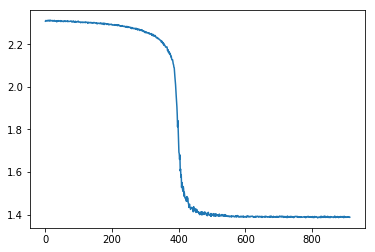

In [25]:
import matplotlib.pyplot as plt
plt.plot(iterations,train_loss)
plt.show();

In [82]:
dtype = torch.FloatTensor
n_iters = 1000
num_epochs = int(n_iters / (len(X_train)/batch_size))

model = LSTMModel(batch_size, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS,N_LAYERS)

# Cross Entropy Loss 
loss_fn = nn.CrossEntropyLoss().type(dtype)

# batch GD
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1,weight_decay = 0, amsgrad=False)

# Create RNN
input_dim = 22
seq_dim = 1000

train_loss = []
iterations = []
train_acc = []

X_valid_tensor = torch.from_numpy(X_valid.reshape(-1, seq_dim, input_dim))
X_train_tensor = torch.from_numpy(X_train.reshape(-1, seq_dim, input_dim))

print("num_epochs = ", num_epochs)
print("n_iters = ", n_iters)
print("starting training..")

count = 0
for epoch in range(num_epochs):
    print("epoch=",epoch)
    # reset hidden states
    model.hidden = model.init_hidden()
    for i, (signals, labels) in enumerate(train_loader):
        train  = Variable(signals.view(-1, seq_dim, input_dim))
        labels = Variable(labels )
        
        # Clear gradients
        optimizer.zero_grad()
        
        # reset hidden states
        #model.hidden = model.init_hidden() 
                
        # Forward propagation
        outputs = model(train.float())
        
        # Calculate softmax and cross entropy loss
        loss = loss_fn(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
                    
        #print("parameters===",list(model.parameters())[0].data)

        count += 1
        train_loss.append(loss.data)
        iterations.append(count
                          
        if count % 1 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            
            
            y_pred_valid = model( X_valid_tensor.float())
            val_acc = get_accuracy(y_pred_valid, Y_valid,batch_size=X_valid.shape[0])
            
            y_pred_train = model( X_train_tensor.float())
            train_acc = get_accuracy(y_pred_train, Y_train,batch_size=X_train.shape[0])
            
            print('Iteration: {}  Loss: {}  Train Accuracy: {} Valid Accuracy: {} %'.format(count, loss.data,train_acc,
                                                                                            val_acc))
            '''
            # Iterate through test dataset
            for signals, labels in valid_loader:
                signals = Variable(signals.view(-1, seq_dim, input_dim))
                #print(signals.shape)
                # Forward propagation
                outputs_valid = model(signals.float())

                # Get predictions from the maximum value
                predicted = torch.max(outputs_valid.data, 1)[1]
                
                # Total number of labels
                total += labels.size(0)
                correct += (predicted == labels).sum()
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            train_loss.append(loss.data)
            iterations.append(count)
            train_acc.append(accuracy)
            print('Iteration: {}  Loss: {}  Valid Accuracy: {} %'.format(count, loss.data, accuracy))
            '''
                                   

SyntaxError: invalid syntax (<ipython-input-82-e672ddfbaeab>, line 62)

In [40]:
X_valid_tensor = torch.from_numpy(X_valid[0:10000].reshape(-1, seq_dim, input_dim))
print(X_valid_tensor.shape)
y_pred_valid = model( X_valid_tensor.float())
val_acc = get_accuracy(y_pred_valid, Y_valid[0:10000],
    batch_size=10000)
print('validation accuracy:', val_acc)


torch.Size([10000, 500, 22])
validation accuracy: 23.51


In [36]:
X_test_tensor = torch.from_numpy(X_test.reshape(-1, seq_dim, input_dim))
y_pred_test = model( X_test_tensor.float())
test_acc = get_accuracy(y_pred_test, Y_test,
    batch_size=X_test.shape[0])
print('test accuracy:', test_acc)


KeyboardInterrupt: 